# TS-RAPOOC

### Based on RAPOOC algorithm proposed by Omar Odibat (2014)

- Step 1: Divide rows into two separate parts
- Step 2: Decide which part will be devided among all generated clusters
- Step 3: Divide the chosen cluster in columns or rows, the one that has the highest coherence
- Step 4: Check the number of clusters generated this way, if the number of clusters is reached, break, else return to step 2

In [413]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import glob
import multiprocessing
from operator import attrgetter
from sklearn.datasets import make_biclusters
from sklearn.datasets import samples_generator as sg
from sklearn.preprocessing import MinMaxScaler

from metrics import *
from clusterer import *

In [2]:
%%latex
Define H for a new term 'z' in X
$$
H_{1}(I,J,X,z) =H_{0}(I,J,X) \cdot \frac{(I-1)}{(I+1)} + \frac{|2|}{(I)(I+1)} \cdot \sum_{x \epsilon X} {h(x,z,J)}
$$

<IPython.core.display.Latex object>

In [533]:
data = pd.read_csv('TestData/SimulatedDataCoherence/BiclusterABC_high.csv',header=None)
# data = (data - 0.5) * 2.0


scaler = MinMaxScaler()
scaler.fit(data)
data = scaler.transform(data)*2-1

data = np.concatenate((data,data),axis=0)

# data,_,_ = sg._shuffle(data)

In [290]:
class ClusterMaps(object):
    def __init__(self, rho=None, gamma=None, H = 0):
        self.gamma = gamma
        self.rho = rho
        self.H = H
    
    def __str__(self):
        return ("rho: \n"+ str(self.rho) + "\ngamma: \n" + str(self.gamma) + "\nH: \n " + str(self.H))

In [460]:
class TsRapooc(object):
    def __init__(self, data, n_clusters = 5):
        self._D = np.array(data)
        self._n_clusters = n_clusters
        self._labels = list()
        self._I, self._J = data.shape
        
    @property
    def n_clusters(self):
        return self._n_clusters
    
    @property
    def data(self):
        return self._D
    
    @property
    def labels(self):
        return _labels
    
    def fit(self):
        n_iteration = 0
        n_clusters = 0
        for n_iteration in range(0, self._n_clusters-1):
            if n_iteration == 0:
                try:
                    initial_partition = BisectingClusterer(self._D).fit_rows()
                    self._labels.append(ClusterMaps(np.where(initial_partition==0)[0],
                                        np.arange(self._J),
                                        PairBasedCoherence(self._D[np.where(initial_partition==0)]).HP))

                    self._labels.append(ClusterMaps(np.where(initial_partition==1)[0],
                                       np.arange(self._J),
                                       PairBasedCoherence(self._D[np.where(initial_partition==1)]).HP))
                except IndexError:
                    print("Index error")
                    print("partition 0")
                    print(np.where(initial_partition==0))
                    print("partition 1")
                    print(np.where(initial_partition==1))
            else:
                self._partition()
            # print(n_iteration+1)
        
    def _partition(self):
        least_coherent, least_coherent_index = self._find_least_coherent()
        lowest_cluster = self._D[np.ix_(least_coherent.rho,least_coherent.gamma)]
        self._bisect_bicluster(lowest_cluster, least_coherent,least_coherent_index)
    
    def _find_least_coherent(self):
        
        return self._labels[self._labels.index(min(filter(lambda cluster: len(cluster.gamma)>2 and len(cluster.rho)>2 ,self._labels),key=attrgetter('H')))], self._labels.index(min(self._labels,key=attrgetter('H')))
    
    def _bisect_bicluster(self,cluster, cluster_node, node_index):
        #which of the biclusters maximize coherence
        rows_map = BisectingClusterer(cluster).fit_rows()
        cols_map = BisectingClusterer(cluster).fit_cols()
        
        flg_alls= 'none'
        
        if(np.all(cols_map) or np.all(rows_map)):
            # if all rows are in the same bicluster, then divide columns
            if(np.all(rows_map)):
                print(rows_map)
                flg_alls = 'cols'
            else:
                print(cols_map)
                flg_alls = 'rows'
        # print('\n'+flg_alls +" labels "+ str(node_index))
        if(flg_alls == 'none'):
            # find the coherences, the ones which raises the average coherences are the ones that are divided
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            avg_cols = (cols_coherence_1 + cols_coherence_2)/2.0
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            avg_rows = (rows_coherence_1 + rows_coherence_2)/2.0
            if (avg_cols>avg_rows):
                # print('cols division')
                col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], rows_coherence_1)
                self._labels[node_index] = col_cluster_1
                col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], rows_coherence_2)
                self._labels.append(col_cluster_2)
            else:
                # print('rows division')
                row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
                self._labels[node_index] = row_cluster_1
                row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
                self._labels.append(row_cluster_2)
        elif (flg_alls == 'cols'):
            cols_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 0)])]).HP
            cols_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho,cluster_node.gamma[np.flatnonzero(cols_map == 1)])]).HP
            col_cluster_1 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 0)], cols_coherence_1)
            self._labels[node_index] = col_cluster_1
            col_cluster_2 = ClusterMaps(cluster_node.rho
                                        , cluster_node.gamma[np.flatnonzero(cols_map == 1)], cols_coherence_2)
            self._labels.append(col_cluster_2)
        else:
            rows_coherence_1 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 0)],cluster_node.gamma)]).HP
            rows_coherence_2 = PairBasedCoherence(self._D[np.ix_(cluster_node.rho[np.flatnonzero(rows_map == 1)],cluster_node.gamma)]).HP
            row_cluster_1 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 0)], cluster_node.gamma, rows_coherence_1)
            self._labels[node_index] = row_cluster_1
            row_cluster_2 = ClusterMaps(cluster_node.rho[np.flatnonzero(rows_map == 1)], cluster_node.gamma, rows_coherence_2)
            self._labels.append(row_cluster_2)
            
            

In [537]:
tsrapooc = TsRapooc(np.array(data),20)
tsrapooc.fit()

[ 1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.]
[ 1.  1.  1.]
[ 1.  1.  1.]
[ 1.  1.  1.]
[ 1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.]
[ 1.  1.  1.  1.  1.  1.  1.]


0.934831296026 i 0



/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


0.950635032853 i 1

0.979001432539 i 2

0.945967567964 i 3

0.979001432539 i 4

0.940209973104 i 5

0.979186953696 i 6

0.93493383212 i 7

0.982167860948 i 8

0.956000086139 i 9

0.956000086139 i 10

0.968155194456 i 11

0.950266618384 i 12

0.992865605024 i 13

0.930829501953 i 14

0.974611552968 i 15

0.94775669184 i 16

0.957950260479 i 17

0.950502295994 i 18

0.962824213105 i 19

13


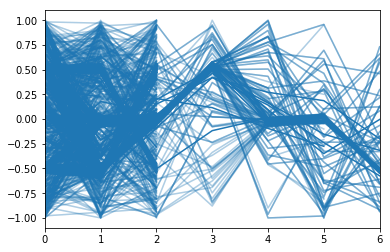

In [540]:
i = 0
max_coherence = 0
cluster = 0
for bicluster in tsrapooc._labels:
    print(str(bicluster.H) +" i "+ str(i)+"\n")
    if (bicluster.H > max_coherence):
        cluster = i
        max_coherence=bicluster.H
    sns.tsplot(data= tsrapooc._D[np.ix_(tsrapooc._labels[i].rho,tsrapooc._labels[i].gamma)],err_style="unit_traces")
    i+=1
    
print(cluster)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


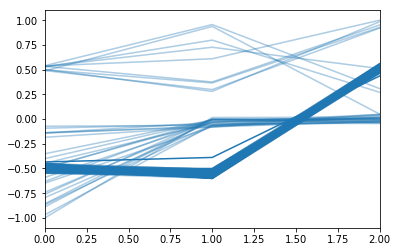

In [553]:
sns.tsplot(data= tsrapooc._D[np.ix_(tsrapooc._labels[2].rho,tsrapooc._labels[2].gamma)],err_style="unit_traces")

In [552]:
print(tsrapooc._labels[15])

rho: 
[  2   5  10  13  18  21  24  25  28  32  34  40  44  47  48  50  53  60
  61  63  64  65  69  73  90  91 107 111 112 115 117 118 121 123 124 125
 127 128 135 136 138 140 141 144 145 146 152 154 156 157 162 163 167 169
 173 175 176 177 178 179 180 181 188 189 190 191 192 197 198 302 305 310
 313 318 321 324 325 328 332 334 340 344 347 348 350 353 360 361 363 364
 365 369 373 390 391 407 411 412 415 417 418 421 423 424 425 427 428 435
 436 438 440 441 444 445 446 452 454 456 457 462 463 467 469 473 475 476
 477 478 479 480 481 488 489 490 491 492 497 498]
gamma: 
[6 7 8]
H: 
 0.974611552968


/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


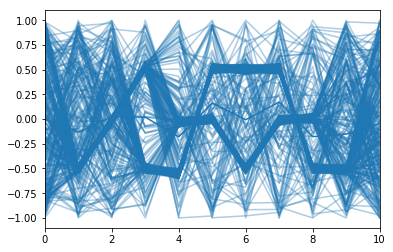

In [543]:
sns.tsplot(data= np.array(data),err_style="unit_traces")

# Sci-kit learn datasets

In [478]:

test_data, rows, columns = make_biclusters(
    shape=(100, 7), n_clusters=5, noise=5,
    shuffle=False, random_state=0)

scaler = MinMaxScaler()
scaler.fit(test_data)
test_data = scaler.transform(test_data)*2-1

test_data, row_idx, col_idx = sg._shuffle(test_data, random_state=0)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


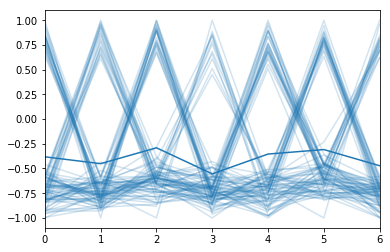

In [479]:
ax = sns.tsplot(data=np.array(test_data), err_style="unit_traces")

In [480]:
tsrapooc_test = TsRapooc(test_data,5)

In [481]:
tsrapooc_test.fit()

0.994054418484 i 0



/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


0.953503235137 i 1

0.887408172216 i 2

0.880653249788 i 3

0.994901197969 i 4

4


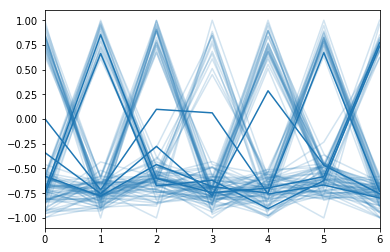

In [482]:
i = 0
max_coherence = 0
cluster = 0
for bicluster in tsrapooc_test._labels:
    print(str(bicluster.H) +" i "+ str(i)+"\n")
    if (bicluster.H > max_coherence):
        cluster = i
        max_coherence=bicluster.H
    sns.tsplot(data= tsrapooc_test._D[np.ix_(tsrapooc_test._labels[i].rho,tsrapooc_test._labels[i].gamma)],err_style="unit_traces")
    i+=1
    
print(cluster)

/home/a20125359/anaconda3/envs/Biclustering/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


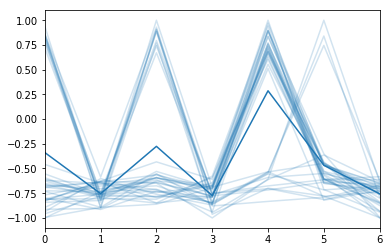

In [485]:
sns.tsplot(data= tsrapooc_test._D[np.ix_(tsrapooc_test._labels[2].rho,tsrapooc_test._labels[2].gamma)],err_style="unit_traces")

In [486]:
print(tsrapooc_test._labels[2])

rho: 
[ 2  3  4  7  8 10 20 21 24 25 28 29 30 31 34 37 38 41 42 43 45 47 51 52 55
 59 62 63 64 72 78 83 85 86 96 97 98 99]
gamma: 
[0 1 2 3 4 5 6]
H: 
 0.887408172216
